Team name on Kaggle: tripleatom

Group Member:

Sheng Cheng. sc159@rice.edu

Xiaorong Zhang. xz106@rice.edu

# Data preprocessing
## load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('drive/Shareddrives/578_term')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/Shareddrives/578_term

/content/drive/Shareddrives/578_term


In [ ]:
!pip install shap
import shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

#load in training data on each potential synapse
data = pd.read_csv("./data/train_data.csv")

#load in additional features for each neuron
feature_weights = pd.read_csv("./data/feature_weights.csv")
morph_embeddings = pd.read_csv("./data/morph_embeddings.csv")

#we need to first load and merge the leaderboard data to have the same format as the training set
lb_data = pd.read_csv("./data/leaderboard_data.csv")

In [ ]:
# join all feature_weight_i columns into a single np.array column
feature_weights["feature_weights"] = (
    feature_weights.filter(regex="feature_weight_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the feature_weight_i columns
feature_weights.drop(
    feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True
)

# join all morph_embed_i columns into a single np.array column
morph_embeddings["morph_embeddings"] = (
    morph_embeddings.filter(regex="morph_emb_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the morph_embed_i columns
morph_embeddings.drop(
    morph_embeddings.filter(regex="morph_emb_").columns, axis=1, inplace=True
)

find neurons without morphology information, and do interpolation

In [ ]:
# extract pre neucleaus_id columns and convert into np array
pre_id = data['pre_nucleus_id']
pre_id = np.array(pre_id)

morph_id = morph_embeddings['nucleus_id']
morph_id = np.array(morph_id)

# find the indices of the missing morph_id
miss_morph_id  = np.setdiff1d(pre_id, morph_id)

# find the miss id in test data
pre_id_lb = lb_data['pre_nucleus_id']
pre_id_lb = np.array(pre_id_lb)

# find the indices of the missing morph_id
miss_morph_id_test  = np.setdiff1d(pre_id_lb, morph_id)

# merge miss_morph_id and miss_morph_id_test
miss_morph_id = np.union1d(miss_morph_id, miss_morph_id_test)

In [ ]:
# extract the pre_id and pre_neucleus_x, pre_neucleus_y, pre_neucleus_z columns to a new dataframe
pre_data = data[['pre_nucleus_id', 'pre_nucleus_x', 'pre_nucleus_y', 'pre_nucleus_z']]
# change the name to 'x', 'y', 'z'
pre_data = pre_data.rename(columns={'pre_nucleus_x':'x', 'pre_nucleus_y':'y', 'pre_nucleus_z':'z'})
# change the name to 'nucleus_id'
pre_data = pre_data.rename(columns={'pre_nucleus_id':'nucleus_id'})

# extract the post_id and post_neucleus_x, post_neucleus_y, post_neucleus_z columns to a new dataframe
post_data = data[['post_nucleus_id', 'post_nucleus_x', 'post_nucleus_y', 'post_nucleus_z']]
post_data = post_data.rename(columns={'post_nucleus_x':'x', 'post_nucleus_y':'y', 'post_nucleus_z':'z'})
post_data = post_data.rename(columns={'post_nucleus_id':'nucleus_id'})

pre_lb_data = lb_data[['pre_nucleus_id', 'pre_nucleus_x', 'pre_nucleus_y', 'pre_nucleus_z']]
pre_lb_data = pre_lb_data.rename(columns={'pre_nucleus_x':'x', 'pre_nucleus_y':'y', 'pre_nucleus_z':'z'})
pre_lb_data = pre_lb_data.rename(columns={'pre_nucleus_id':'nucleus_id'})

post_lb_data = lb_data[['post_nucleus_id', 'post_nucleus_x', 'post_nucleus_y', 'post_nucleus_z']]
post_lb_data = post_lb_data.rename(columns={'post_nucleus_x':'x', 'post_nucleus_y':'y', 'post_nucleus_z':'z'})
post_lb_data = post_lb_data.rename(columns={'post_nucleus_id':'nucleus_id'})

# concat the pre_data, post_data, pre_lb_data, post_lb_data and drop the duplicate rows
position_data = pd.concat([pre_data, post_data, pre_lb_data, post_lb_data])
position_data = position_data.drop_duplicates(subset=['nucleus_id'], keep='first')

position_data = np.array(position_data)

In [ ]:
# average k nearest neighbor's average to fill the missing morphological data

k = 3

for id in miss_morph_id:
    # find the k nearest neighbors
    id_position = position_data[position_data[:,0] == id]
    id_position = id_position[:,1:4]
    # calculate the distance between id and all other neurons
    distance = np.linalg.norm(position_data[:,1:4] - id_position, axis=1)
    # find the k nearest neighbors index
    k_nearest_index = np.argsort(distance)[1:k+1]
    # extract the k nearest neighbors' id
    k_nearest_id = position_data[k_nearest_index,0]

    # extract the k nearest neighbors' morphological data
    k_nearest_morph = morph_embeddings[morph_embeddings['nucleus_id'].isin(k_nearest_id)]
    # calculate the average of the k nearest neighbors' morphological data
    k_nearest_morph = np.array(k_nearest_morph['morph_embeddings'])
    k_nearest_morph_mean = np.mean(k_nearest_morph, axis=0)

    # append a new row to the morph_embeddings dataframe, neuron_id = id, morphological data = k_nearest_morph
    morph_embeddings = pd.concat([morph_embeddings, pd.DataFrame([[id, k_nearest_morph_mean]], columns=['nucleus_id', 'morph_embeddings'])])

In [ ]:
data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

# Feature
## Feature engineering

functional similarity

In [ ]:
#cosine similarity function
def row_feature_similarity(row):
    pre = row["pre_feature_weights"]
    post = row["post_feature_weights"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

# compute the cosine similarity between the pre- and post- feature weights
data["fw_similarity"] = data.apply(row_feature_similarity, axis=1)

structural similarity

In [ ]:
def row_morph_similarity(row):
    pre = row["pre_morph_embeddings"]
    post = row["post_morph_embeddings"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

data["me_similarity"] = data.apply(row_morph_similarity, axis=1)

nucleus distance

In [ ]:
data['nucleus_dist'] = np.sqrt((data['pre_nucleus_x'] - data['post_nucleus_x'])**2 + (data['pre_nucleus_y'] - data['post_nucleus_y'])**2 + (data['pre_nucleus_z'] - data['post_nucleus_z'])**2)
# normalize the nucleus_dist
data['nucleus_dist'] = (data['nucleus_dist'] - data['nucleus_dist'].mean()) / data['nucleus_dist'].std()

## Feature selection

adp distance

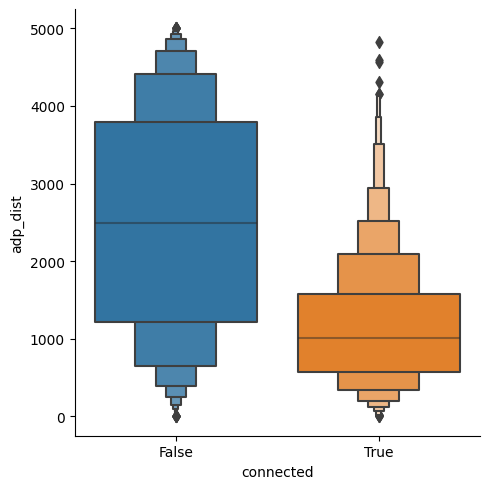

In [ ]:
sns.catplot(data=data, x='connected', y='adp_dist', kind='boxen')

post skeletal distance to soma

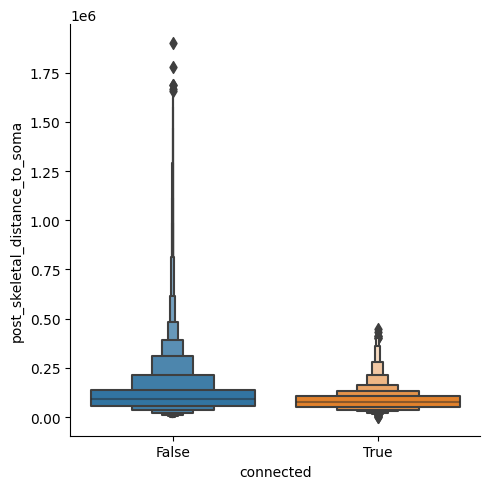

In [ ]:
sns.catplot(data=data, x='connected', y='post_skeletal_distance_to_soma', kind='boxen')

nucleus distance

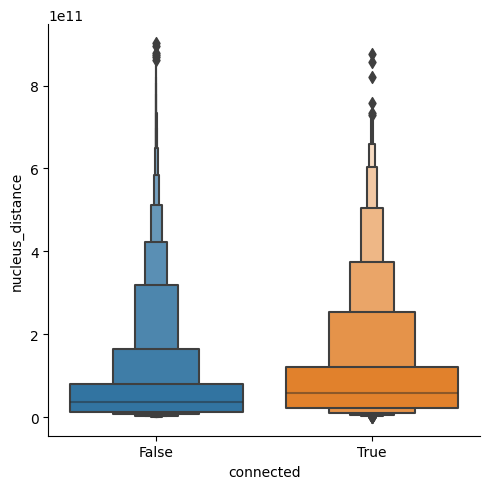

In [ ]:
# calculate nucleus distance
data["nucleus_distance"] = (
    data["post_nucleus_x"] - data["pre_nucleus_x"]
) ** 2 + (data["post_nucleus_y"] - data["pre_nucleus_y"]) ** 2 + (
    data["post_nucleus_z"] - data["pre_nucleus_z"]
) ** 2

# plot violin plot of nucleus distance
sns.catplot(data=data, x='connected', y='nucleus_distance', kind='boxen')

connection propability for differnet compartments of post-synaptic neuron

Text(0, 0.5, 'Connection probability')

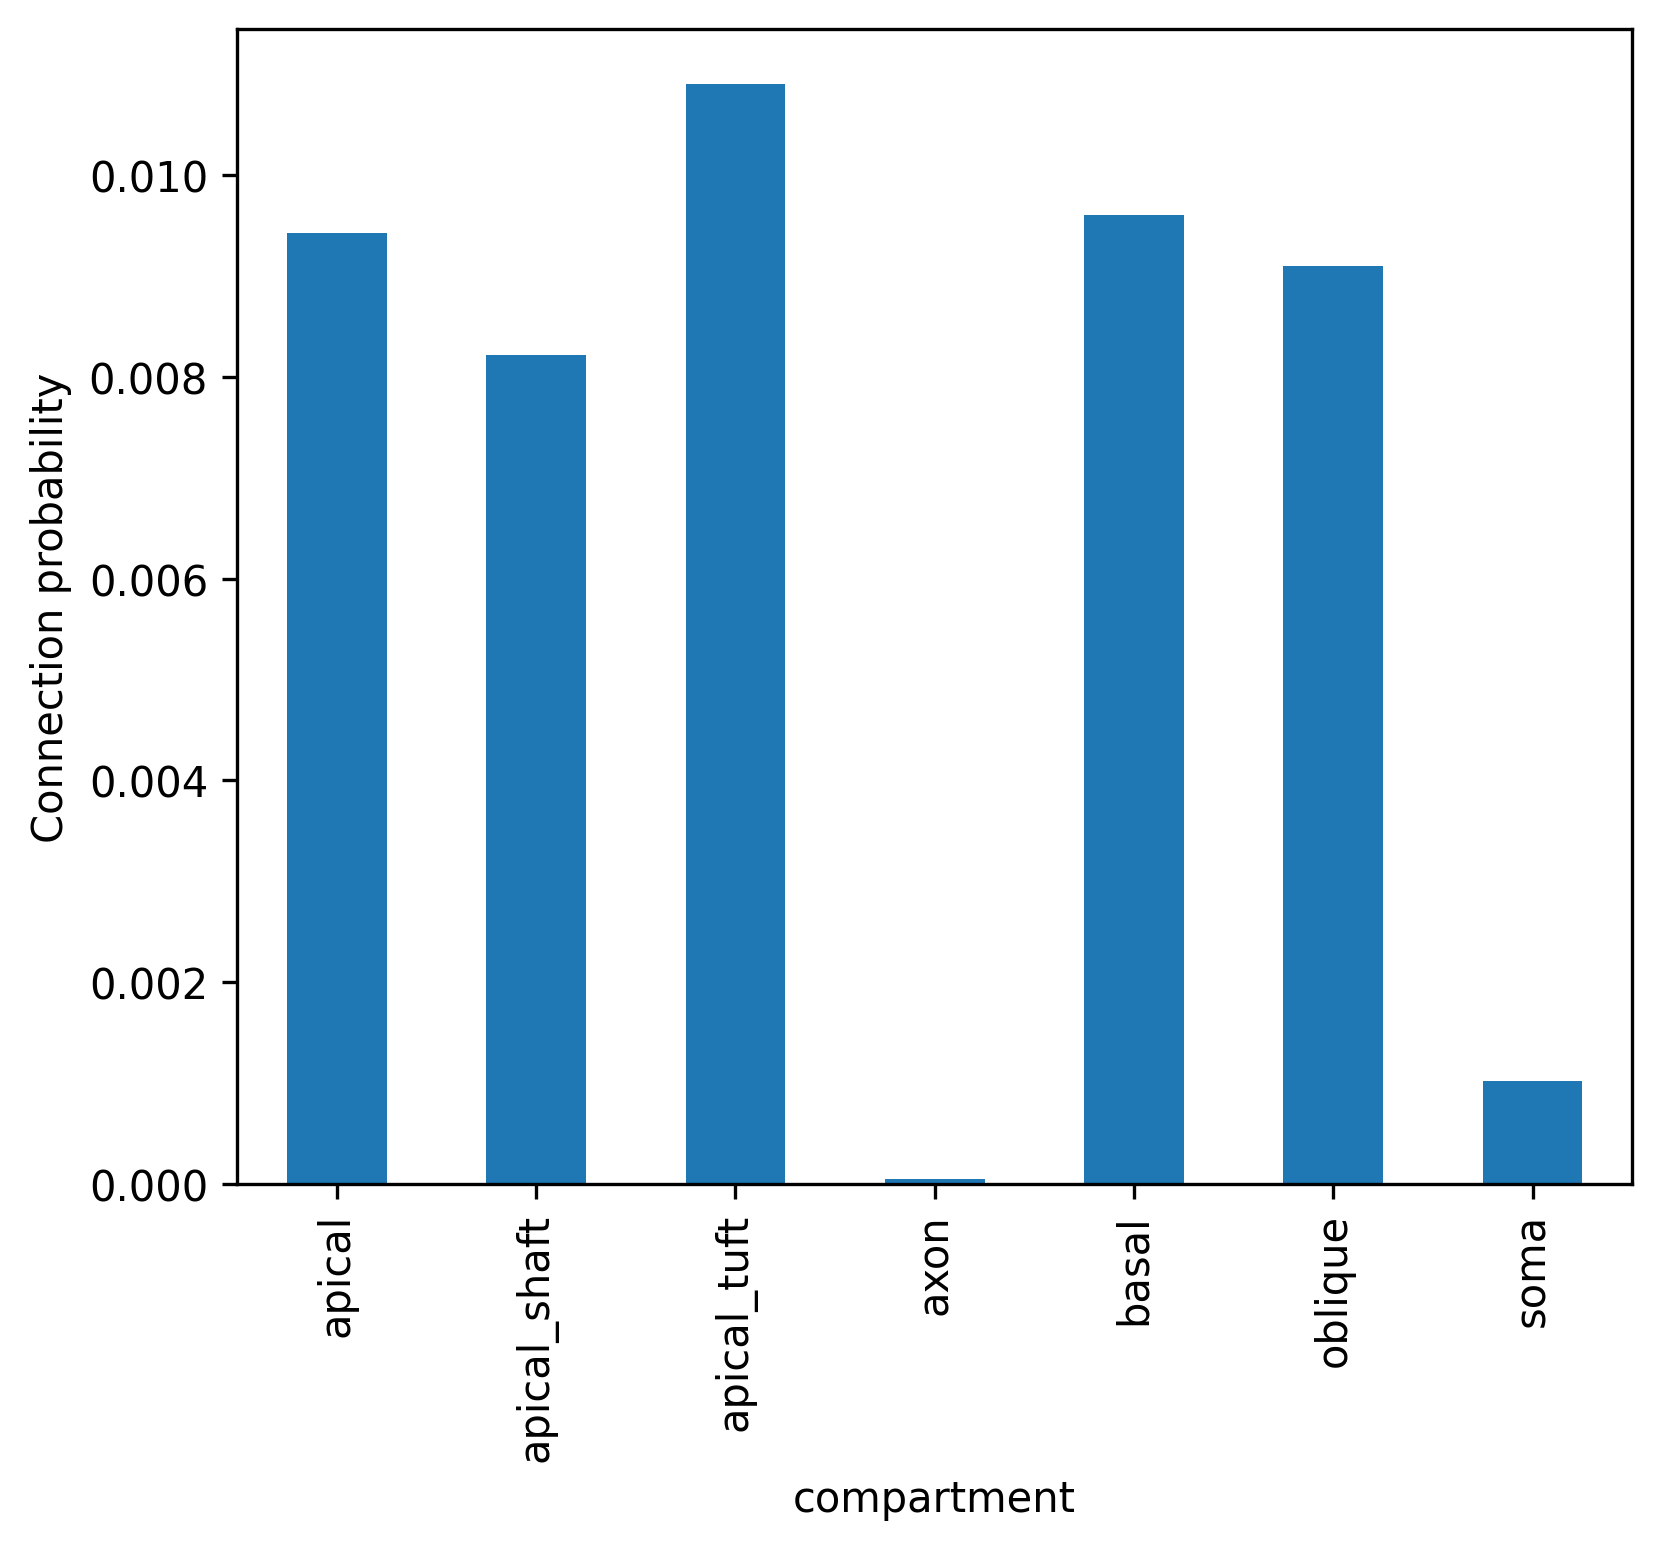

In [ ]:
# calculate the connection probability for each compartment
# calculate how many synapses are in each compartment, and how many are connected
compartment_counts = data.groupby("compartment")["connected"].value_counts().unstack()
# calculate the connection probability for each compartment
compartment_counts["connection_probability"] = (
    compartment_counts[True] / compartment_counts.sum(axis=1)
)

figure, ax = plt.subplots(figsize=(6, 5), dpi=300)
# plot the connection probability for each compartment
compartment_counts["connection_probability"].plot.bar()
plt.ylabel("Connection probability")

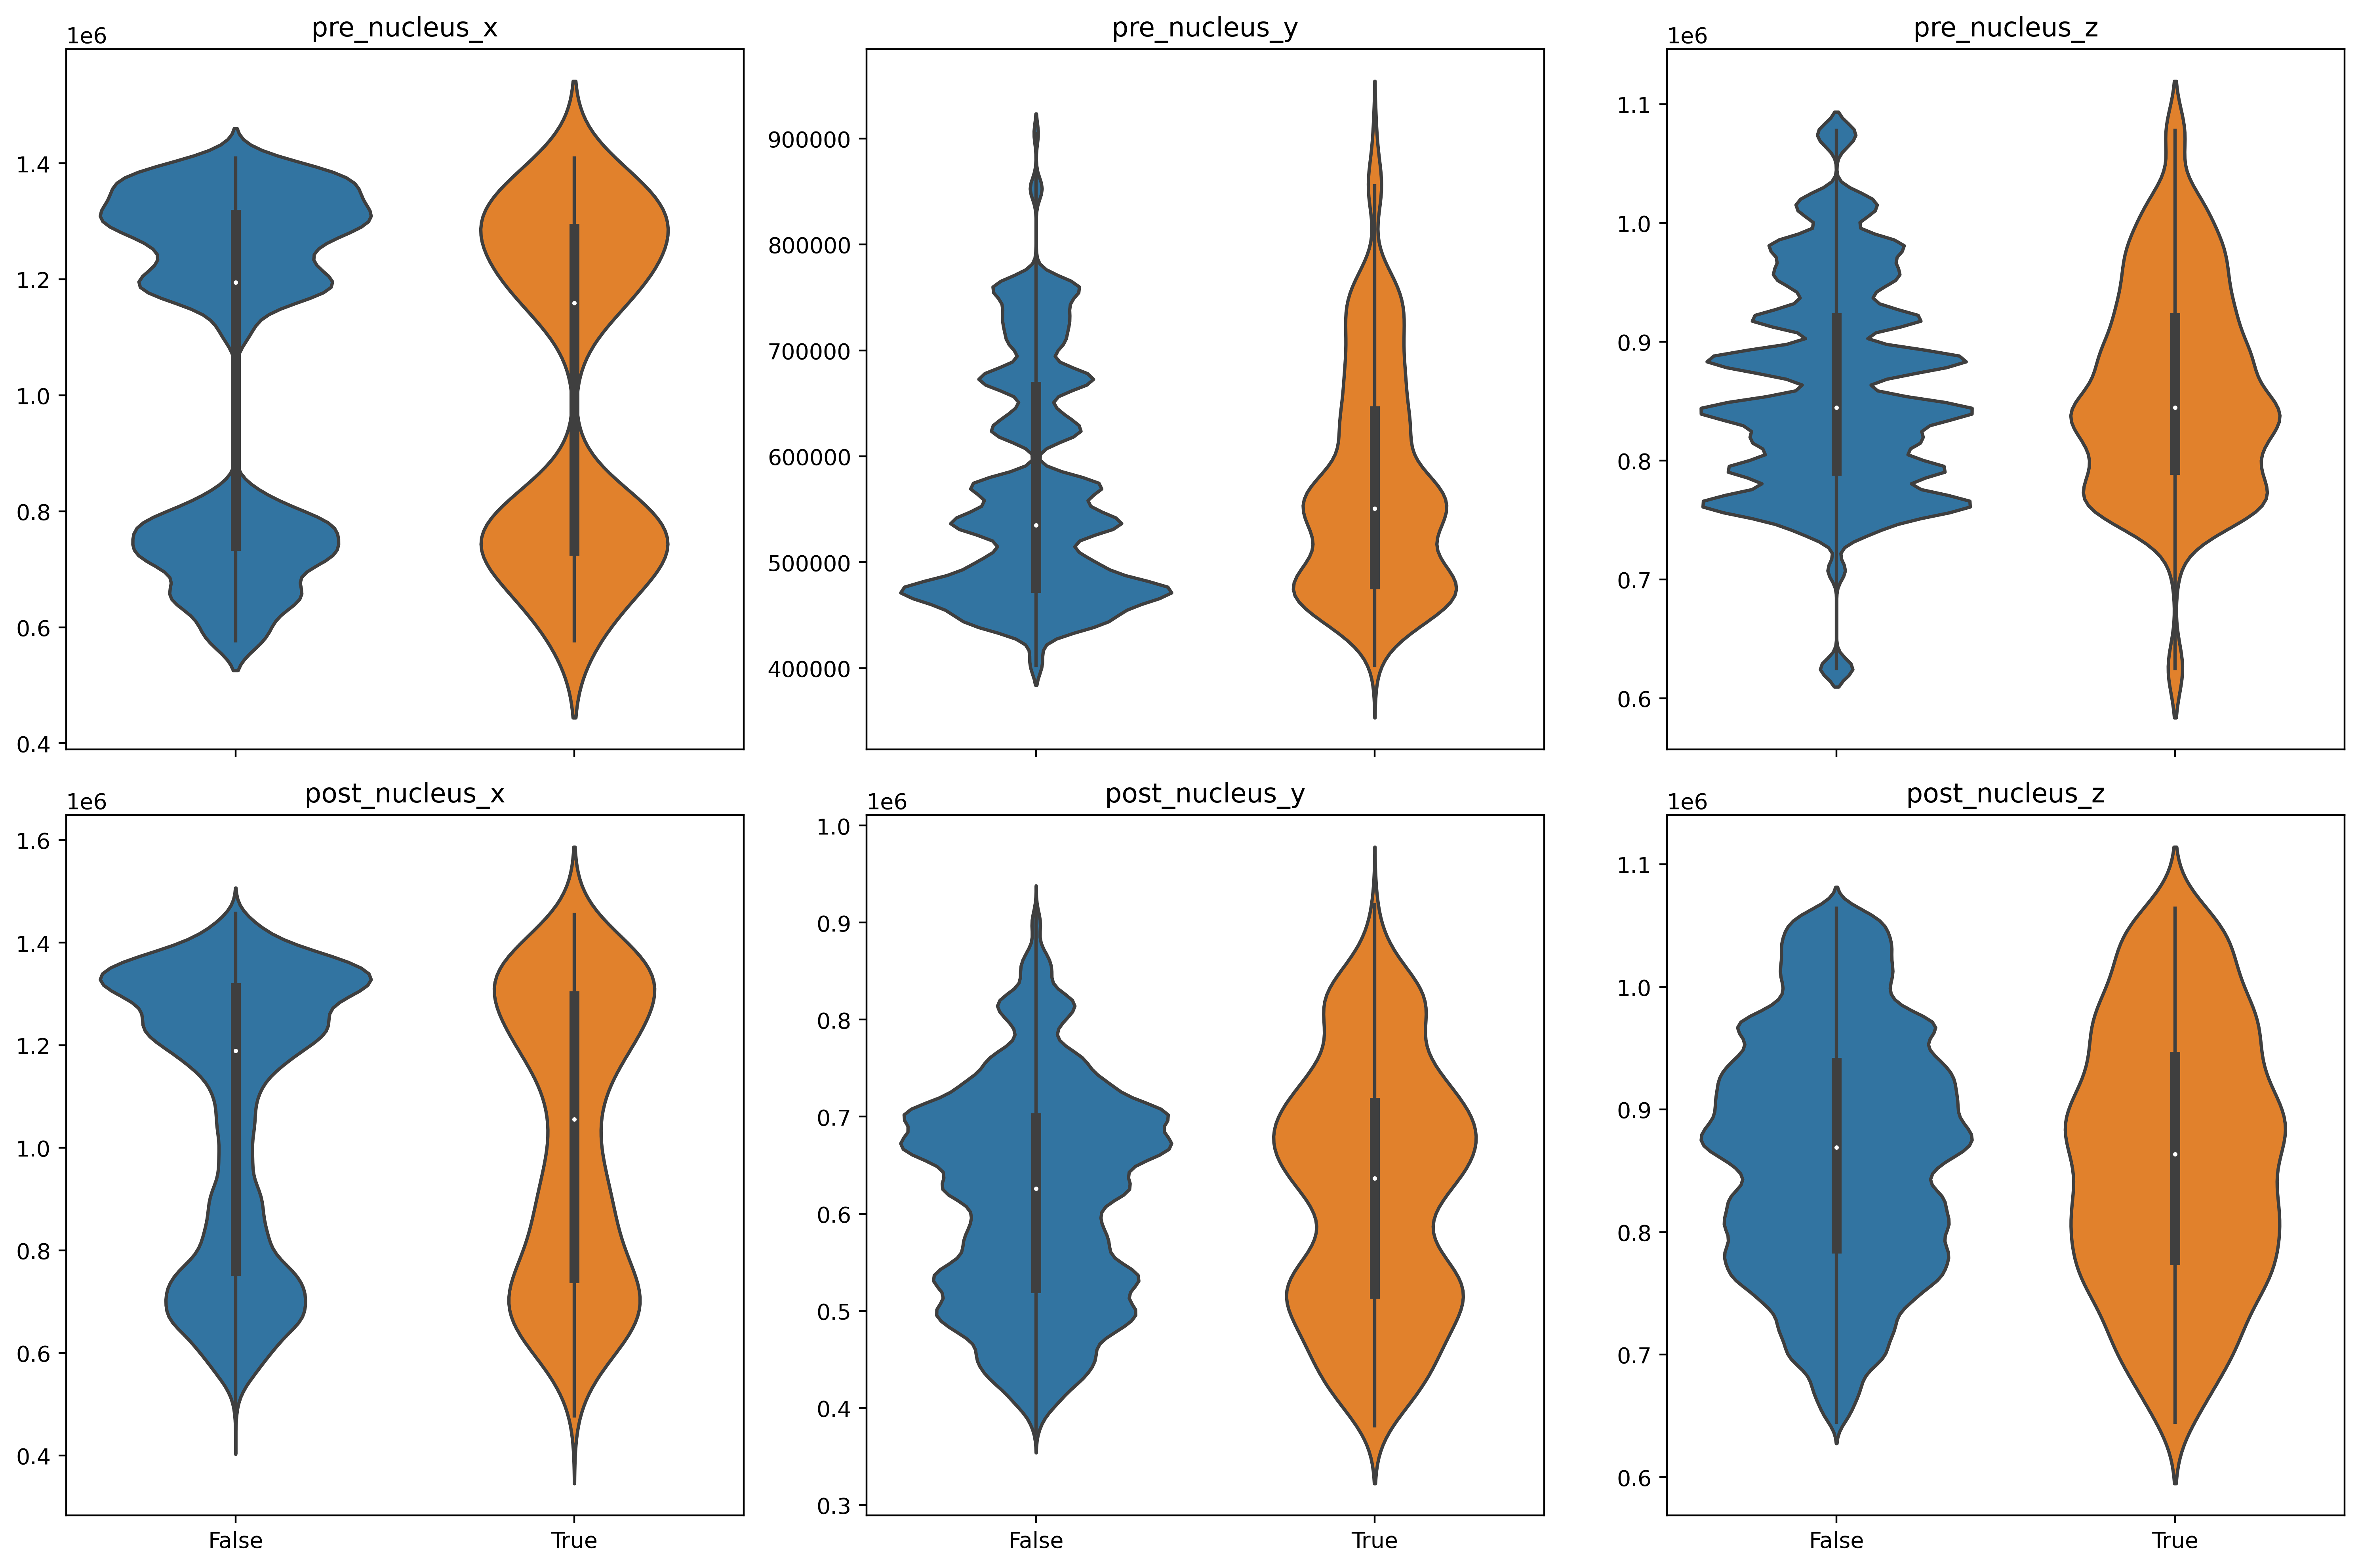

In [ ]:
# plot a 2*3 grid of violin plots of the 6 features, pre_neucleus_x, pre_neucleus_y, pre_neucleus_z, post_neucleus_x, post_neucleus_y, post_neucleus_z
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, dpi=400)
for i, feature in enumerate(["pre_nucleus_x", "pre_nucleus_y", "pre_nucleus_z", "post_nucleus_x", "post_nucleus_y", "post_nucleus_z"]):
    sns.violinplot(data=data, x='connected', y=feature, ax=axes[i//3][i%3])
    axes[i//3][i%3].set_ylabel("")
    axes[i//3][i%3].set_xlabel("")
    axes[i//3][i%3].set_title(feature)
plt.tight_layout()


In [ ]:
drop_columns=['pre_feature_weights', 'post_feature_weights', 'pre_morph_embeddings', 'post_morph_embeddings', 'pre_nucleus_id', 'post_nucleus_id', 'ID']

remain_columns=['adp_dist','post_skeletal_distance_to_soma', 'pre_skeletal_distance_to_soma','fw_similarity', 'me_similarity', 'post_nucleus_x', 'nucleus_dist']

relation_onehot_columns=[
    ['pre_brain_area', 'post_brain_area'], # 1. use xor to get new feature.  2. no, found out connected neurons can located in both.
                        ]

relation_number_columns=[
    ['pre_nucleus_x','pre_nucleus_y','pre_nucleus_z', 'post_nucleus_y', 'post_nucleus_z'], # get the distance between pre and post
    ['pre_rf_x', 'pre_rf_y', 'post_rf_x', 'post_rf_y'],
]

question_columns=['pre_oracle', 'pre_test_score', 'post_oracle', 'post_test_score'] # oracle relates to neuron reliability, test_score relates to similarity.

target_columns=['connected']

remain_columns.extend(question_columns)
data2=data[remain_columns].copy(deep=True)

data2['compartment']=data['compartment'].astype("category")
data2['target']=data['connected']

In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   adp_dist                        185832 non-null  float64 
 1   post_skeletal_distance_to_soma  185832 non-null  float64 
 2   pre_skeletal_distance_to_soma   185832 non-null  float64 
 3   fw_similarity                   185832 non-null  float64 
 4   me_similarity                   185832 non-null  float64 
 5   post_nucleus_x                  185832 non-null  int64   
 6   pre_oracle                      185832 non-null  float64 
 7   pre_test_score                  185832 non-null  float64 
 8   post_oracle                     185832 non-null  float64 
 9   post_test_score                 185832 non-null  float64 
 10  nucleus_dist                    185832 non-null  float64 
 11  compartment                     185832 non-null  category
 12  ta

# LGBM

## downsample and weak classifier

In [ ]:
!pip install lightgbm==3.3.3

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
import lightgbm as lgb

x=data2.drop(columns=['target'])
y=data2['target']*1

ratio=y.value_counts()[0]/y.value_counts()[1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

#######################################################
# get best hyper parameters with 0.8 training data
#######################################################
# sample negatives, to make balanced dataset
np.random.seed(42)
def eval_balanced_accuracy_score(labels, preds):
    is_higher_better = True
    preds=preds>0.5
    score=balanced_accuracy_score(labels, preds)
    return "bacc", score, is_higher_better

data3=data2.copy(deep=True)

# generate 100 balanced datasets and get 100 models
models=[0]*100
best_lrs=[0]*100
for sample_ix in range(100):
    print(f"**************{sample_ix}*****************")
    # data
    data3_neg=data3[data3['target']==False].sample(n=1366)
    data3_pos=data3[data3['target']==True]
    data3=pd.concat([data3_pos,data3_neg])

    data3['target'].value_counts()

    x=data3.drop(columns=['target'])
    y=data3['target']*1

    ratio=y.value_counts()[0]/y.value_counts()[1]


    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

    #model
    best_acc=-1
    for lr in [1e-2, 1e-3, 1e-4, 1e-5]:
        print(f"-----{lr}------")
        fit_params = {"early_stopping_rounds": 10,
                      "eval_metric": eval_balanced_accuracy_score,
                      "eval_set": [(x_test, y_test)],
                      'eval_names': ['valid'],
                      'verbose': 100,
                      'feature_name': 'auto',  # that's actually the default
                      'categorical_feature': 'auto'  # that's actually the default
                    }
        model = lgb.LGBMClassifier(
                                 scale_pos_weight=ratio,
                                 num_leaves=100, max_depth=20,
                                 random_state=314,
                                 silent=True,
                                 n_estimators=2000,
                                 colsample_bytree=0.8,
                                 subsample=0.9,
                                 learning_rate=lr,
                                 objective="binary"
                                 )
        model.fit(x_train, y_train, **fit_params)

        # predict on test data
        pred_test = model.predict(x_test)

        # compute accuracy
        print(f"accuracy: {accuracy_score(y_test, pred_test)}")

        # confusion matrix
        print(confusion_matrix(y_test, pred_test))

        # compute balanced accuracy
        acc=balanced_accuracy_score(y_test, pred_test)
        print(
            f"balanced accuracy: {acc}"
        )

        if acc>best_acc:
            best_acc=acc
            models[sample_ix]=model
            best_lrs[sample_ix]=lr

**************0*****************
-----0.01------
accuracy: 0.7842778793418648
[[189  85]
 [ 33 240]]
balanced accuracy: 0.7844509505093447
-----0.001------
accuracy: 0.7824497257769653
[[187  87]
 [ 32 241]]
balanced accuracy: 0.7826328173043502
-----0.0001------
accuracy: 0.7824497257769653
[[172 102]
 [ 17 256]]
balanced accuracy: 0.7827330820031551
-----1e-05------
accuracy: 0.4990859232175503
[[  0 274]
 [  0 273]]
balanced accuracy: 0.5
**************1*****************
-----0.01------
accuracy: 0.7714808043875686
[[183  91]
 [ 34 239]]
balanced accuracy: 0.7716705435683537
-----0.001------
accuracy: 0.7586837294332724
[[181  93]
 [ 39 234]]
balanced accuracy: 0.7588633993743483
-----0.0001------
accuracy: 0.7696526508226691
[[168 106]
 [ 20 253]]
balanced accuracy: 0.7699393064356568
-----1e-05------
accuracy: 0.4990859232175503
[[  0 274]
 [  0 273]]
balanced accuracy: 0.5
**************2*****************
-----0.01------
accuracy: 0.7769652650822669
[[196  78]
 [ 44 229]]
balance

## ensemble

### voting

In [ ]:
# ensemble
x=data2.drop(columns=['target'])
y=data2['target']*1
ratio=y.value_counts()[0]/y.value_counts()[1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
# x_test=x
# y_test=y

# voting
preds=[]
for model in models:
    # predict on test data
    pred_test = model.predict(x_test)
    preds.append(pred_test)
preds=np.array(preds)
preds=preds.sum(axis=0) # n_samples, range(0,100)
thresh=90
preds[preds<thresh]=0
preds[preds>=thresh]=1

# compute accuracy
print(f"voting accuracy: {accuracy_score(y_test, preds)}")

# confusion matrix
print(confusion_matrix(y_test, preds))

# compute balanced accuracy
acc=balanced_accuracy_score(y_test, preds)
print(
    f"voting balanced accuracy: {acc}"
)


voting accuracy: 0.7718675168832566
[[28459  8435]
 [   44   229]]
voting balanced accuracy: 0.805099938820869


### linear combination

In [ ]:
# ensemble
from sklearn.linear_model import LogisticRegression

x=data2.drop(columns=['target'])
y=data2['target']*1
ratio=y.value_counts()[0]/y.value_counts()[1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# linera combination
preds=[]
for model in models:
    # predict on test data
    pred_train = model.predict(x_train)
    preds.append(pred_train)
preds=np.array(preds).T # n_samples*100

combine_model=LogisticRegression(random_state=42,class_weight={0: sum(y_train)/len(y_train),1: 1-sum(y_train)/len(y_train)}).fit(preds, y_train)

preds=[]
for model in models:
    # predict on test data
    pred_test = model.predict(x_test)
    preds.append(pred_test)
preds=np.array(preds).T # n_samples*100

# compute accuracy
pred_test = combine_model.predict(preds)
print(f"linear accuracy: {accuracy_score(y_test, pred_test)}")

# confusion matrix
print(confusion_matrix(y_test, pred_test))

# compute balanced accuracy
acc=balanced_accuracy_score(y_test, pred_test)
print(
    f"linear balanced accuracy: {acc}"
)

linear accuracy: 0.7510156859579735
[[27673  9221]
 [   33   240]]
linear balanced accuracy: 0.814594320408274


# Interpretation

In [ ]:
import shap

# 100 models overall importance
# top 20? important ensembled models, feture importance
# top 20? models, 4 categories (TP, TN, FP, FN)
# top 20 models, tree visualization

## 100 models overall importance

In [ ]:
def getFeatureImportance(model, cur_data):
  shap_values = shap.TreeExplainer(model.booster_).shap_values(cur_data)
  importance=np.mean(shap_values[0], axis=0)
  importance=importance/np.sum(importance)
  name=list(cur_data.columns)
  return name, importance

In [ ]:
feature_names=[]
importances=[]
shap.initjs()
for model in models:
  feature_names, importance=getFeatureImportance(model, x_test)
  importances.append(importance)

In [ ]:
importances2=np.array(importances)

In [ ]:
importances2=np.mean(importances2, axis=0)

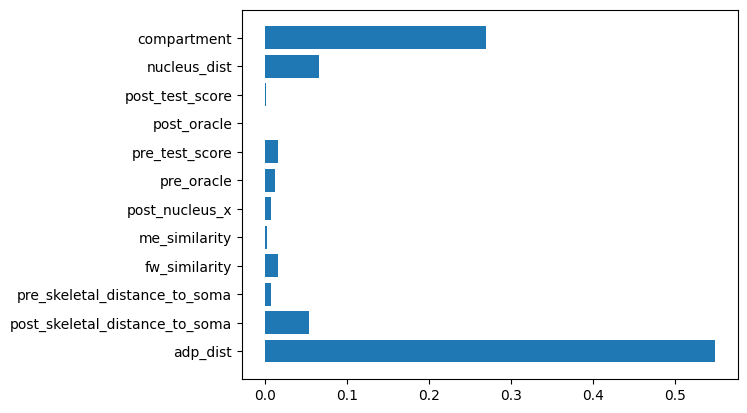

In [ ]:
bars =feature_names
y_pos = np.arange(len(importances2))

# Create horizontal bars
plt.barh(y_pos, importances2)

# Create names on the x-axis
plt.yticks(y_pos, bars)

# Show graphic
plt.show()

## top 10 models

In [ ]:
model_importance=abs(combine_model.coef_[0])

In [ ]:
model_indices=np.argsort(-model_importance)

In [ ]:
importances2=np.array(importances)[model_indices[:10]]
importances2=np.mean(importances2, axis=0)

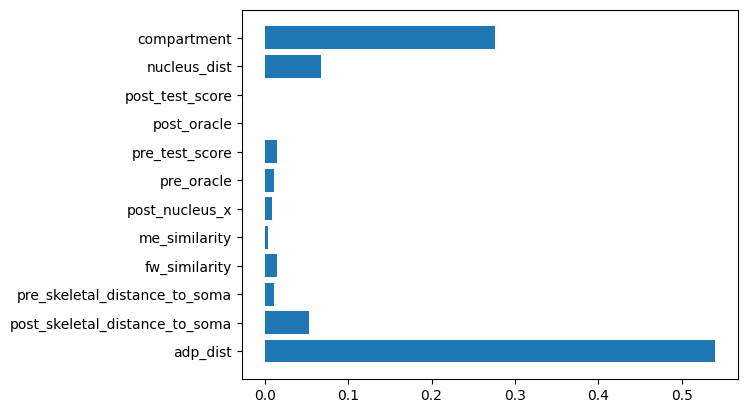

In [ ]:
bars =feature_names
y_pos = np.arange(len(importances2))

# Create horizontal bars
plt.barh(y_pos, importances2)

# Create names on the x-axis
plt.yticks(y_pos, bars)

# Show graphic
plt.show()

## True prediction VS False prediction

In [ ]:
false_prediction_indices=np.where(pred_test!=y_test)[0]
true_prediciton_indices=np.where(pred_test==y_test)[0]

positive_indices=np.where(y_test==1)[0]
neg_indices=np.where(y_test==0)[0]

tp=np.intersect1d(true_prediciton_indices, positive_indices)
tn=np.intersect1d(true_prediciton_indices, neg_indices)
fp=np.intersect1d(false_prediction_indices, positive_indices)
fn=np.intersect1d(false_prediction_indices, neg_indices)

print("tp:", len(tp))
print("tn:", len(tn))
print("fp:", len(fp))
print("fn:", len(fn))

tp: 240
tn: 27673
fp: 33
fn: 9221


*********************
tp
*********************


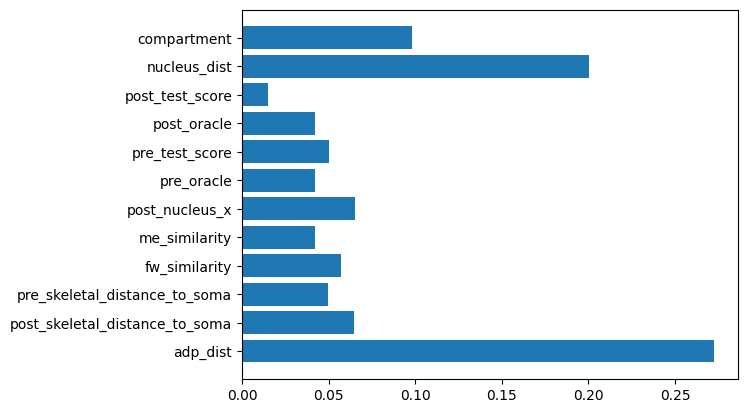

*********************
tn
*********************


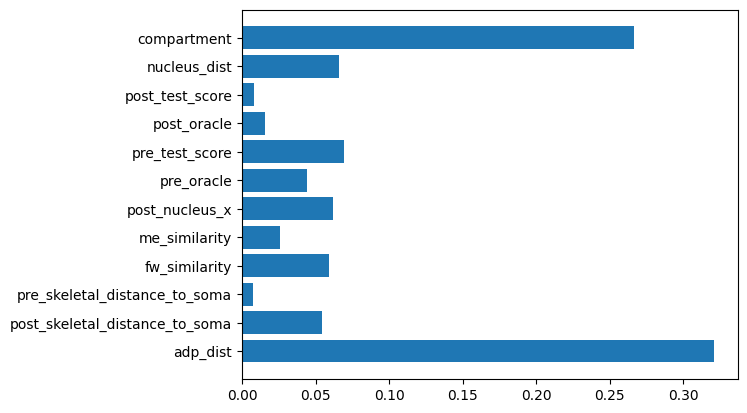

*********************
fp
*********************


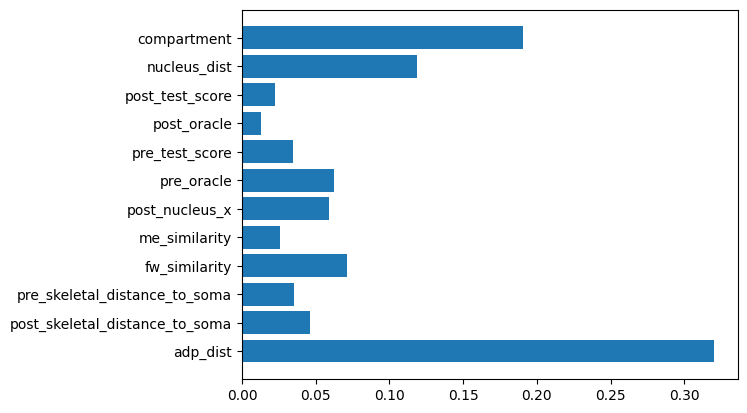

*********************
fn
*********************


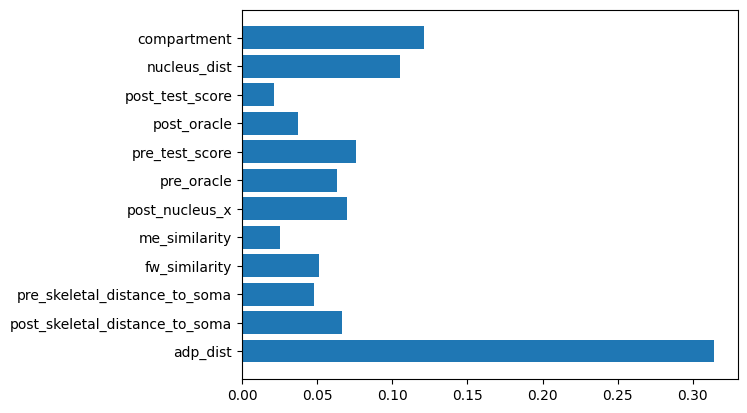

In [ ]:
np.random.seed(42)
cate=["tp", "tn", "fp", "fn"]
for cur_data, cur_cate in zip([tp, tn, fp, fn], cate):
  print("*********************")
  print(cur_cate)
  print("*********************")
  cur_cate_importances=[]
  for cur_index in np.random.choice(cur_data, 10, replace=False):
    name, importance = getFeatureImportance(models[model_indices[0]], x_test.iloc[[cur_index]])
    importance=abs(importance)/np.sum(abs(importance))
    cur_cate_importances.append(importance)
  cur_cate_importances=np.array(cur_cate_importances)
  cur_cate_importances=np.mean(cur_cate_importances, axis=0)

  bars =name
  y_pos = np.arange(len(cur_cate_importances))

  # Create horizontal bars
  plt.barh(y_pos, cur_cate_importances)

  # Create names on the x-axis
  plt.yticks(y_pos, bars)

  # Show graphic
  plt.show()


## Shap Example

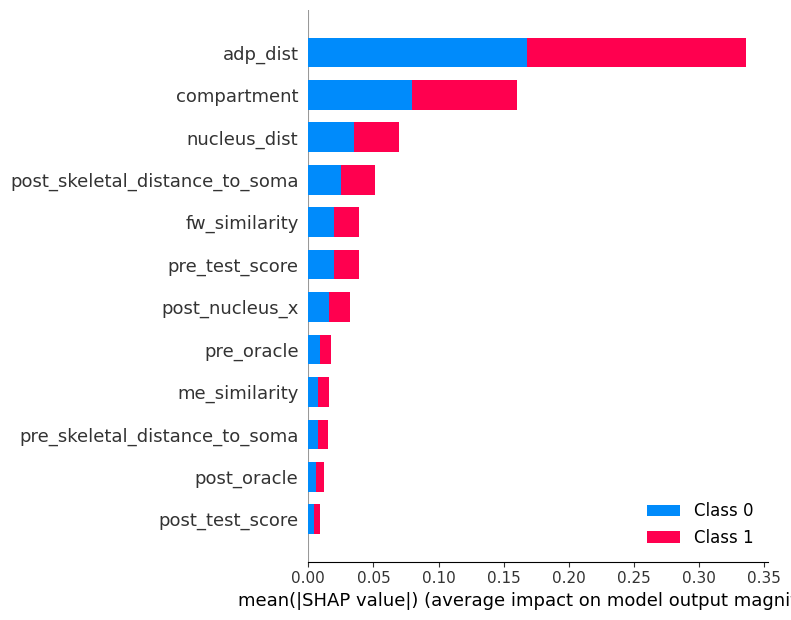

In [ ]:
shap.initjs()
shap_values = shap.TreeExplainer(models[0].booster_).shap_values(x)
shap.summary_plot(shap_values, x, show=True)
# plt.savefig('feature importance.pdf', bbox_inches='tight')

In [ ]:
!pwd

/content/drive/Shareddrives/578_term


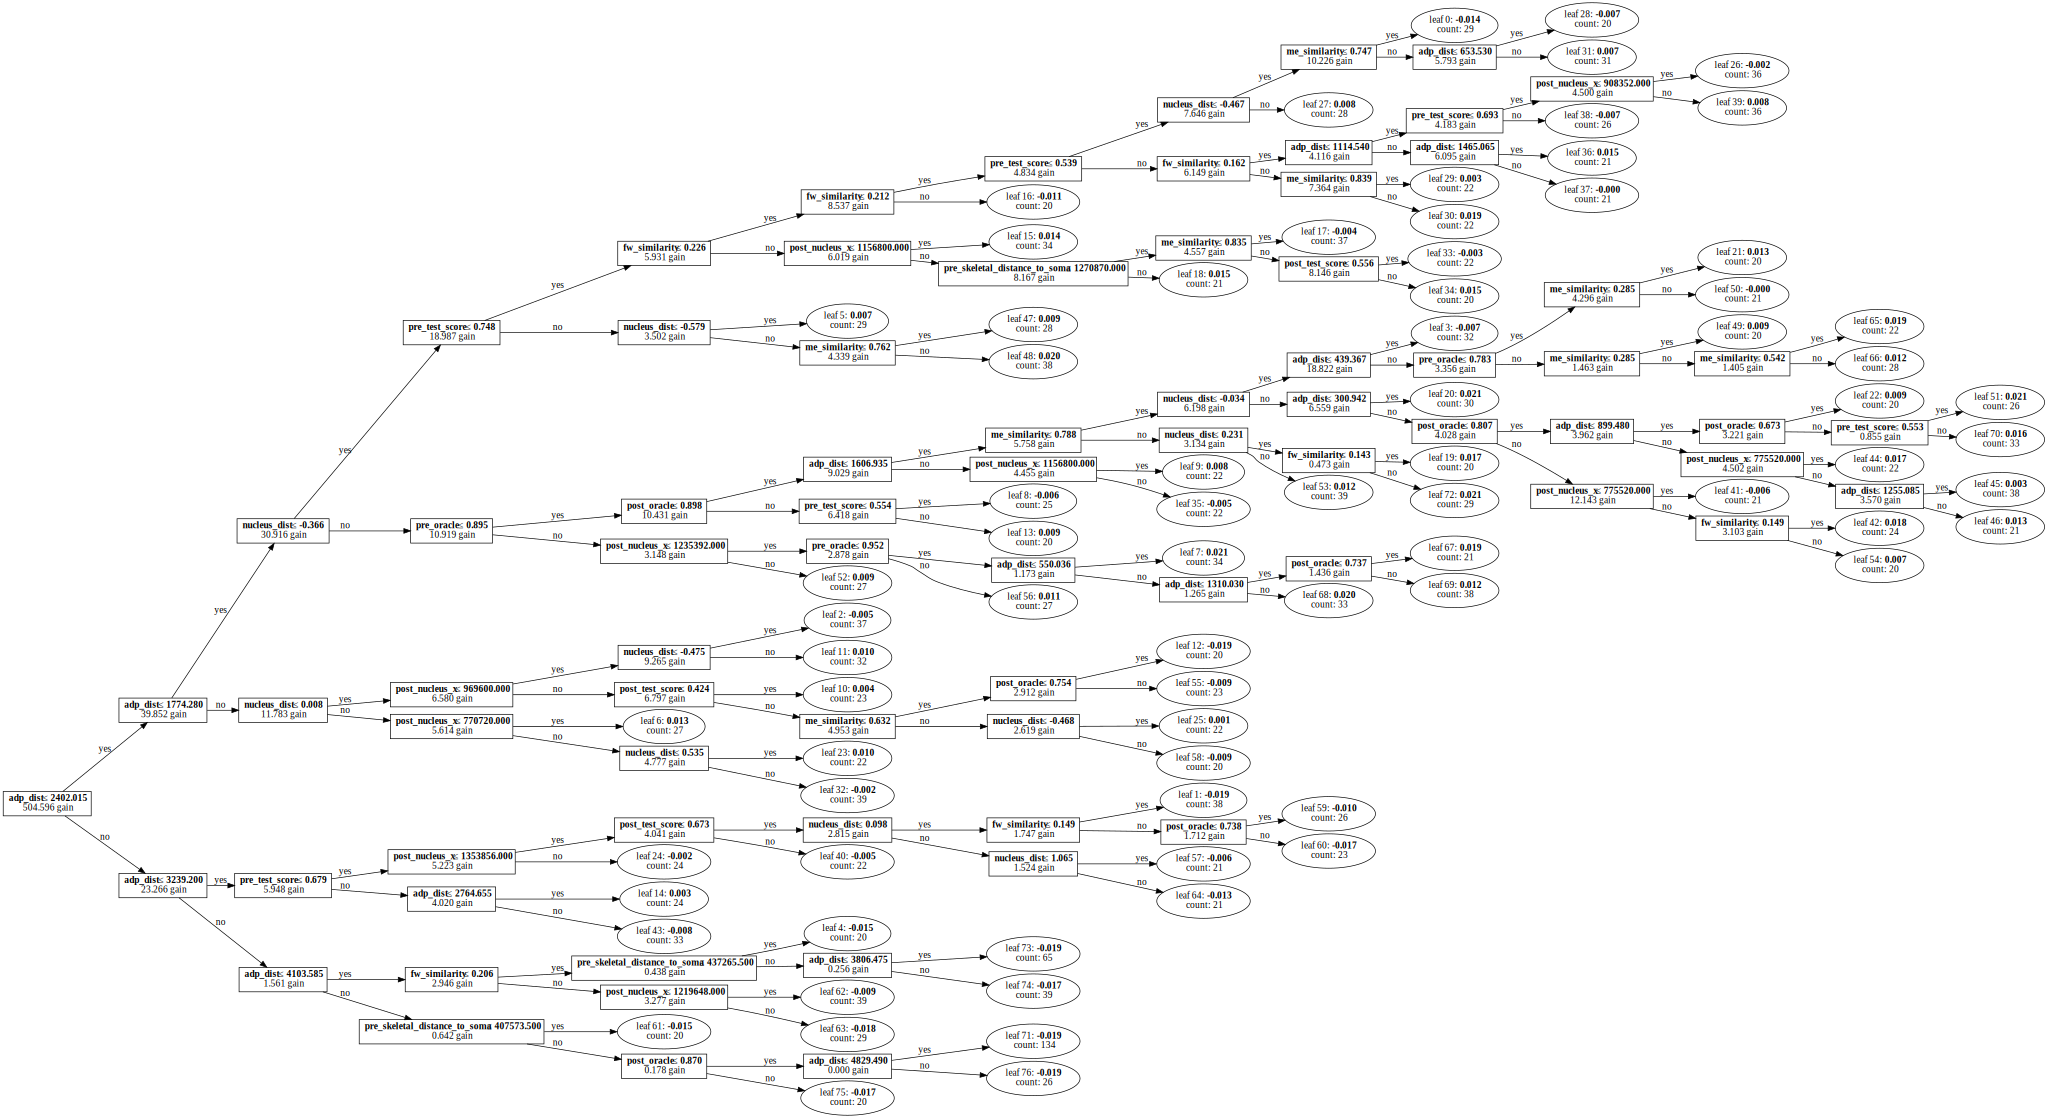

In [ ]:
# display and save decision tree
dot=lgb.create_tree_digraph(models[1], tree_index=0, show_info=['split_gain','leaf_count']) # get display figure
dot.render(directory='treeVisualization2', view=True)  # save
dot # show

# predict

### Load and Merge Leaderboard Data

In [ ]:
lb_data = pd.read_csv("./data/leaderboard_data.csv")
lb_data = (
    lb_data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [ ]:
# compute the cosine similarity between the pre- and post- feature weights
lb_data["fw_similarity"] = lb_data.apply(row_feature_similarity, axis=1)
lb_data["me_similarity"] = lb_data.apply(row_morph_similarity, axis=1)

In [ ]:
drop_columns=['pre_feature_weights', 'post_feature_weights', 'pre_morph_embeddings', 'post_morph_embeddings', 'pre_nucleus_id', 'post_nucleus_id', 'ID' ]

remain_columns=['adp_dist','post_skeletal_distance_to_soma', 'pre_skeletal_distance_to_soma','fw_similarity', 'me_similarity', 'post_nucleus_x']

relation_onehot_columns=[
    ['pre_brain_area', 'post_brain_area'], # 1. use xor to get new feature.  2. no, found out connected neurons can located in both.
                        ]
relation_number_columns=[
    ['pre_nucleus_x','pre_nucleus_y','pre_nucleus_z', 'post_nucleus_y', 'post_nucleus_z'] # get the distance between pre and post
]
question_columns=['pre_oracle', 'pre_test_score', 'post_oracle', 'post_test_score'] # oracle relates to nueron reliability, test_score relates to similarity.

target_columns=['connected']

In [ ]:
remain_columns.extend(question_columns)
lb_data2=lb_data[remain_columns].copy(deep=True)

In [ ]:
lb_data2["nucleus_dist"]=abs(lb_data['pre_nucleus_x']-lb_data['post_nucleus_x'])**2+abs(lb_data['pre_nucleus_y']-lb_data['post_nucleus_y'])**2+abs(lb_data['pre_nucleus_z']-lb_data['post_nucleus_z'])**2
lb_data2["nucleus_dist"]=(lb_data2["nucleus_dist"]-lb_data2["nucleus_dist"].mean())/lb_data2["nucleus_dist"].std()

# lb_data2["rf_dist"] = abs(lb_data['axonal_coor_x']-lb_data['post_rf_x'])**2+abs(lb_data['axonal_coor_y']-lb_data['post_rf_y'])**2
# lb_data2["rf_dist"]=(lb_data2["rf_dist"]-lb_data2["rf_dist"].mean())/lb_data2["rf_dist"].std()

lb_data2['compartment']=lb_data['compartment'].astype("category")

lb_data2['ID']=lb_data['ID']

lb_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42593 entries, 0 to 42592
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   adp_dist                        42593 non-null  float64 
 1   post_skeletal_distance_to_soma  42593 non-null  float64 
 2   pre_skeletal_distance_to_soma   42593 non-null  float64 
 3   fw_similarity                   42593 non-null  float64 
 4   me_similarity                   42593 non-null  float64 
 5   post_nucleus_x                  42593 non-null  int64   
 6   pre_oracle                      42593 non-null  float64 
 7   pre_test_score                  42593 non-null  float64 
 8   post_oracle                     42593 non-null  float64 
 9   post_test_score                 42593 non-null  float64 
 10  nuclues_dist                    42593 non-null  float64 
 11  compartment                     42593 non-null  category
 12  ID                

## pred

In [ ]:
# linera ensemble model
preds=[]
for model in models:
    # predict on test data
    pred_test = model.predict(lb_data2.drop(columns=['ID']))
    preds.append(pred_test)
preds=np.array(preds).T # n_samples*100
lb_data2['connected']= combine_model.predict(preds)


# vote ensemble model
# preds=[]
# for model in models:
#     # predict on test data
#     pred_test = model.predict(lb_data2.drop(columns=['ID']))
#     preds.append(pred_test)
# preds=np.array(preds)
# preds=preds.sum(axis=0) # n_samples, range(0,100)
# thresh=90
# preds[preds<thresh]=0
# preds[preds>=thresh]=1
# lb_data2['connected']=preds

In [ ]:
#columns should be ID, connected
submission_data = lb_data2.filter(['ID','connected'])

In [ ]:
#writing csv files
import datetime
date = datetime.datetime.now().strftime("%d%H%M")
submission_data.to_csv(f'result/lgbm_linear_ensemble_{date}.csv', index=False)